In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [2]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): upper boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    x,y = np.linspace(a,b,n+1), np.linspace(c,d,n+1)
    h = (b-a)/n #intervals are squares
    xx,yy = np.meshgrid(x,y)
    
    diagonals = [1,-4,1]
    offsets = [-1,0,1]
    shape_T = ((n-1),(n-1))
    T = sp.diags(diagonals, offsets, shape=shape_T) #build the inner blocks

    A = sp.block_diag([T]*(n-1))
    A.setdiag(1, -(n-1))
    A.setdiag(1, (n-1)) #build the offdiagonals
    A *= (1/(h**2))
    
    ps = [np.concatenate(([g(x[0],y[j])],np.zeros(n-3),[g(x[-1],y[j])])) for j in range(1,n)] 
    q1 = [g(x[1:n],y[0])] #ss
    q_mid = [np.zeros(n-1) for j in range(2,n-1)]
    qn_min_1 = [g(x[1:n],y[n])]
    qs = q1 + q_mid + qn_min_1 #combine into one list
    fs = [f(np.array([x[1:n],[y[j]]*(n-1)])) for j in range(1,n)]
    
    p = (1/(h**2))*np.concatenate(tuple(ps)) #assemble into p,q,f vectors
    q = (1/(h**2))*np.concatenate(tuple(qs))
    f = np.concatenate(tuple(fs))
    
    U = spla.spsolve(A,f-p-q) #spsolve
    return U

c:\miniconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


<IPython.core.display.Javascript object>


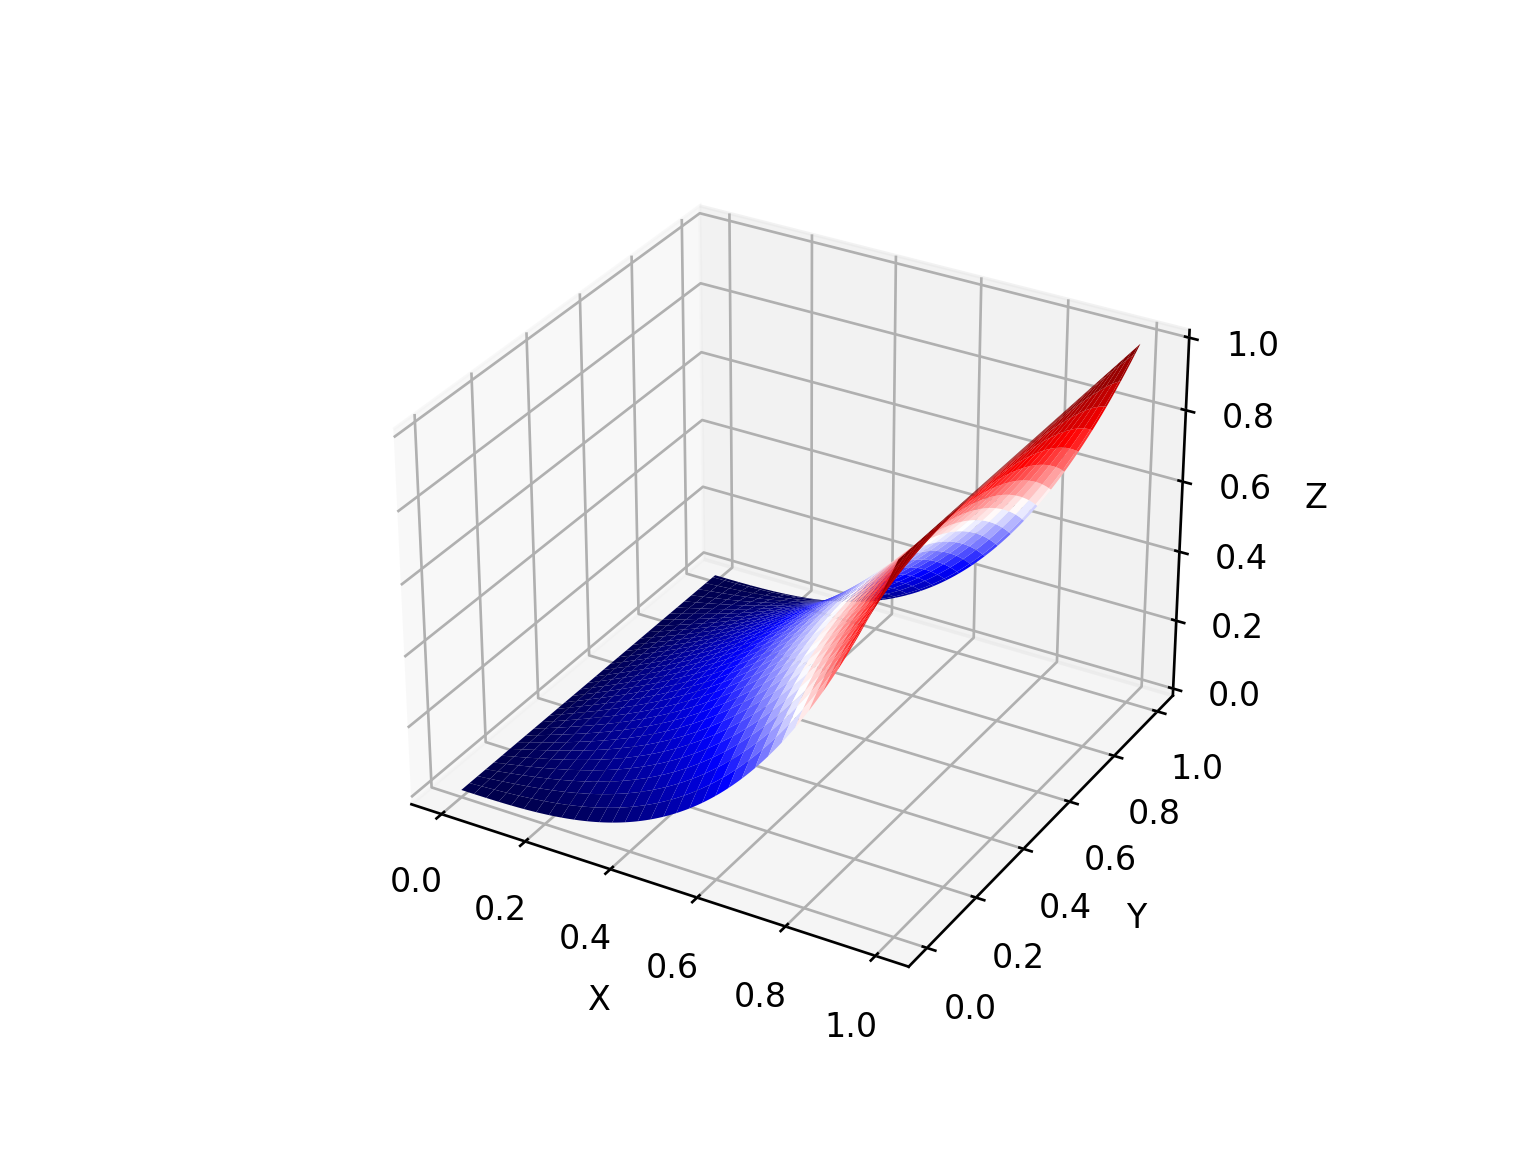

In [3]:
a,b,c,d = 0,1,0,1
f = lambda x: np.zeros(x.shape[1])
g = lambda x,y: x**3
n = 100 #number of subintervals
U = poisson_square(a,b,c,d,f,g,n) #evaluate the dynamics over the grid

x,y = np.linspace(a,b,n+1), np.linspace(c,d,n+1)
xx,yy = np.meshgrid(x,y) #build the grid to plot on

U2 = U.reshape(n-1,n-1)
U = g(xx,yy) #establish the boundary conditions
U[1:-1,1:-1] = U2 #plant the solution in the middle of the block

fig = plt.figure()
ax = plt.axes(projection = '3d') #plot in 3d space
ax.plot_surface(xx,yy,U,cmap='seismic')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

<IPython.core.display.Javascript object>


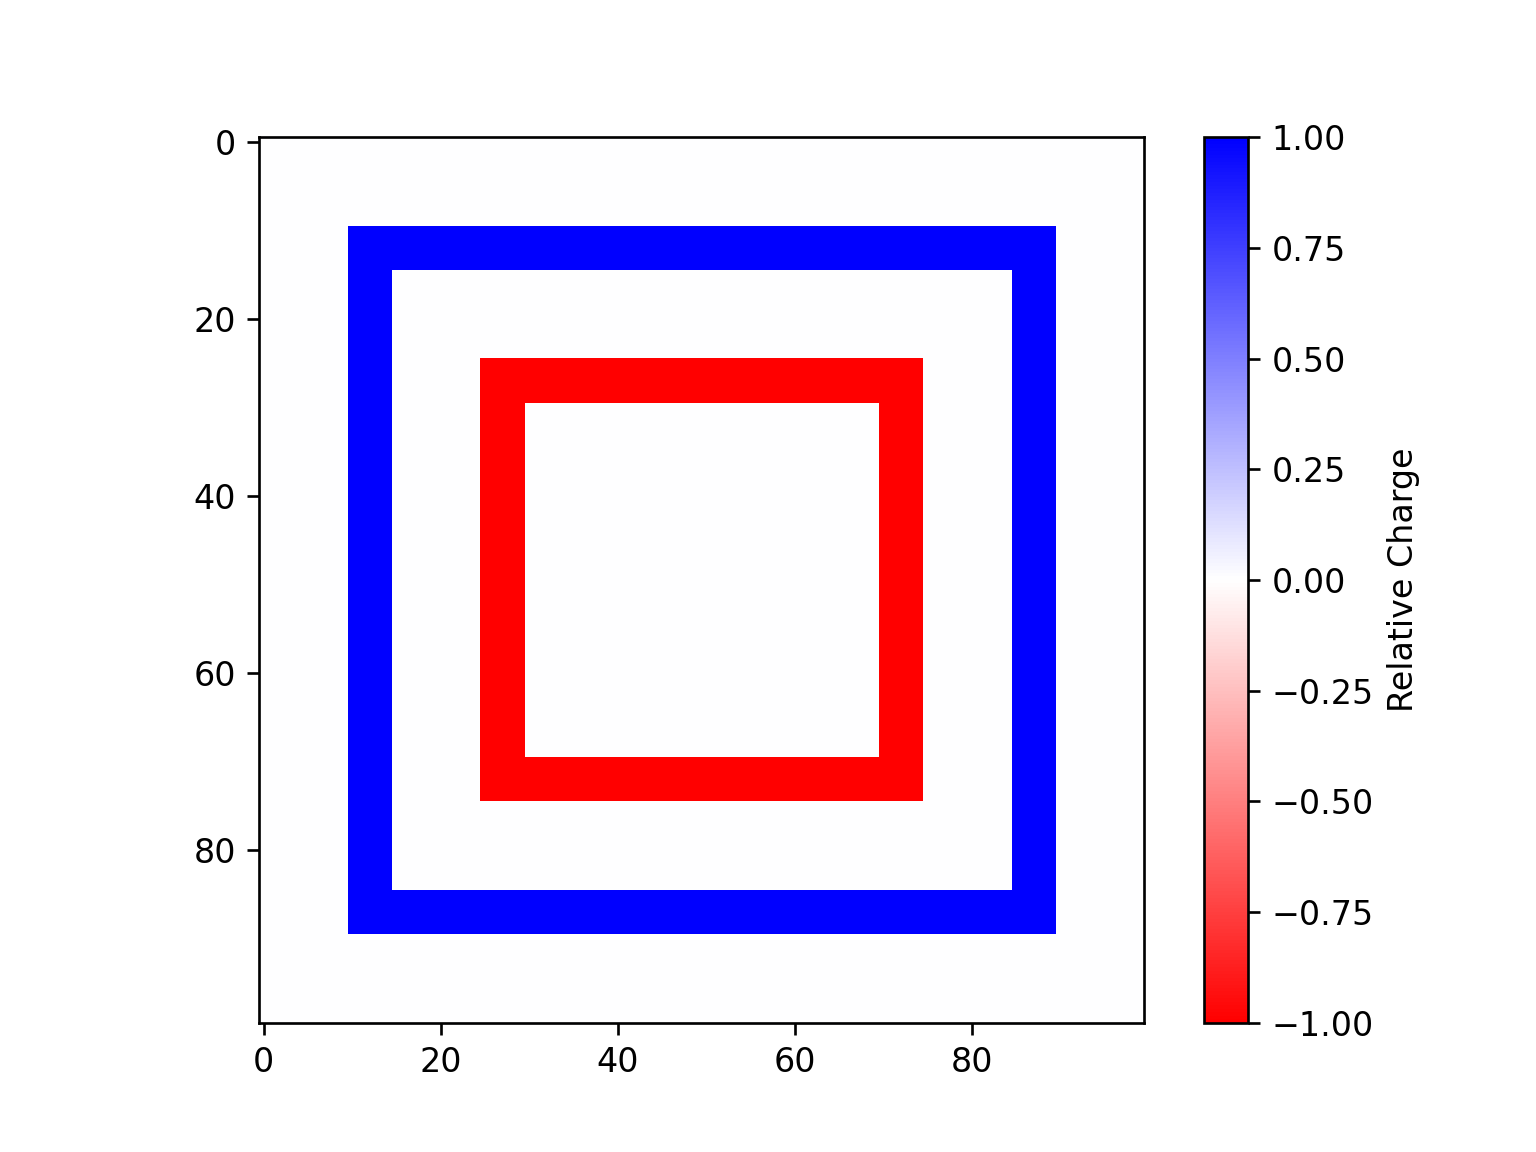

<IPython.core.display.Javascript object>


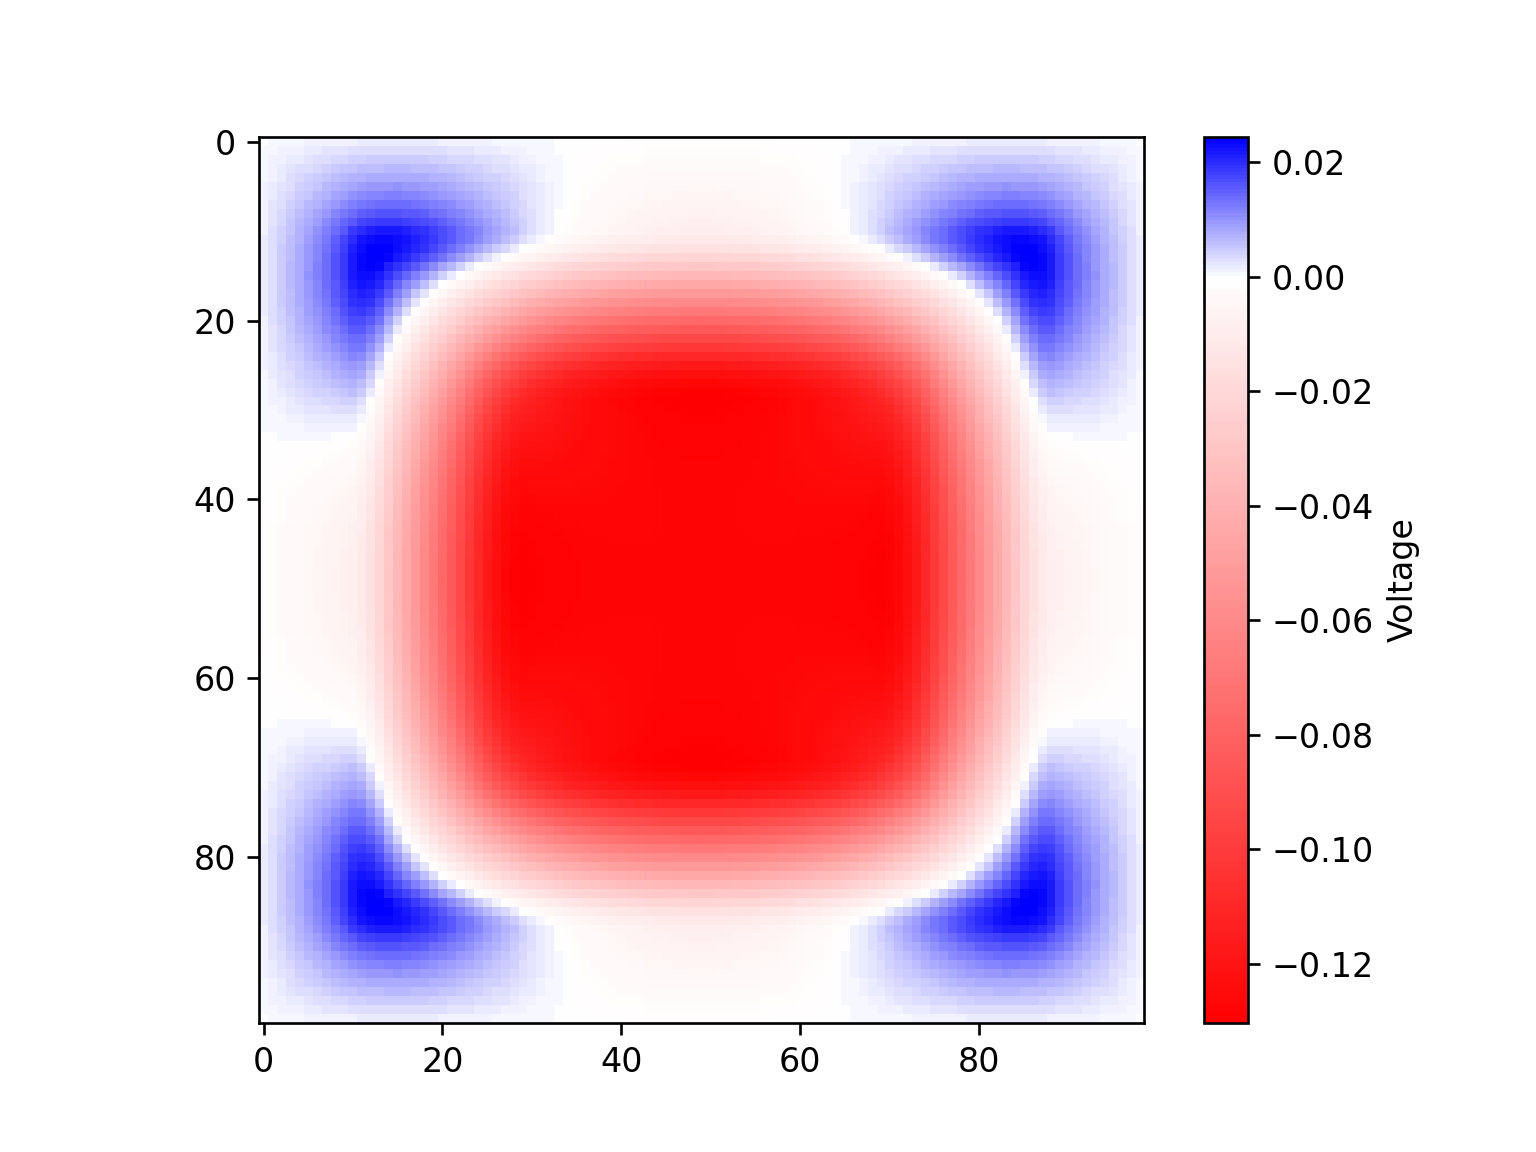

In [4]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

g = lambda x,y: 0*x #establish functions
f = lambda x: -source(x[0],x[1])

U = poisson_square(a1,b1,c1,d1,f,g,n) #get solution 

U = U.reshape(n-1,n-1) #reshape it into a matrix

plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Voltage")
plt.show()